Como o dataset possui poucas linhas de dados, foi comparado a tecnica da separação por train/test com a Leave-one-out Cross Validation (LOOCV)

In [1]:
import tcc_utils
import tratamento_dados_empresa
from keras.initializers import glorot_normal as gl_normal, glorot_uniform as gl_uni, RandomUniform as rnd_uni

x_csv_path = '../data/grendene-indicadores-financeiros-raw.csv'
y_csv_path = '../data/grendene-cotacao-raw.csv'

X = tratamento_dados_empresa.treat_economatica_indicadores_financeiros(x_csv_path)

# Spliting test / train and Feature Scaling
x_train, x_test, y_train, y_test, x_scaler, y_scaler = tratamento_dados_empresa. \
    get_scaled_splits_and_scaler(x_csv_path, y_csv_path, 0.2, 0)

number_hidden_layer = round(x_train.shape[1]*1.5)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 84)                4788      
_________________________________________________________________
dense_2 (Dense)              (None, 84)                7140      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 85        
Total params: 12,013
Trainable params: 12,013
Non-trainable params: 0
_________________________________________________________________
None


<Figure size 576x432 with 0 Axes>

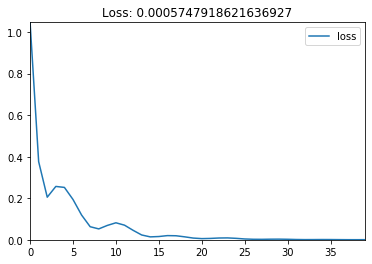

MSE of training: 0.0005836168896745552
MSE of testing: 0.10287126898765564
    Prediction      Real     % error
8     7.486943  8.491036   11.825326
0     6.923376  8.075241   14.264160
7     5.487611  5.156991    6.411107
9     4.177361  4.785659   12.710838
2     5.281531  4.616062   14.416380
1     3.005799  3.669486   18.086656
6     3.805915  3.491649    9.000516
3     2.740126  3.003443    8.767180
10    1.252648  1.377930    9.092041
5     2.215442  0.900556  146.008149
4    -0.523648  0.667981  178.392601


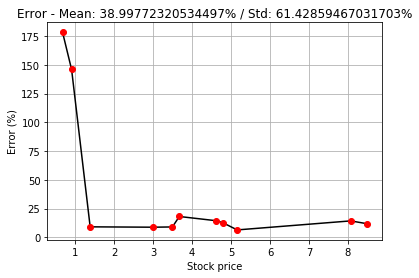

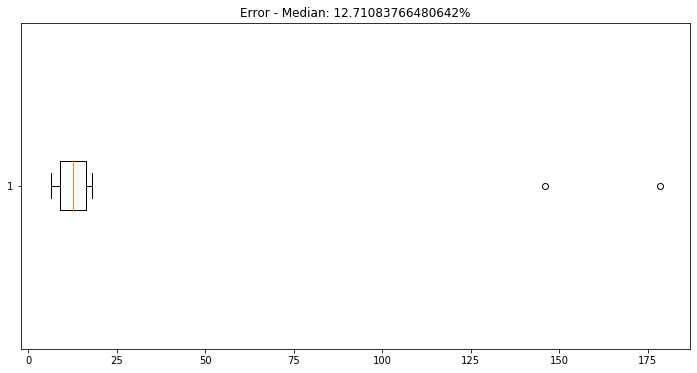

count     11.000000
mean      38.997723
std       61.428595
min        6.411107
25%        9.046279
50%       12.710838
75%       16.251518
max      178.392601
Name: % error, dtype: float64


In [2]:
# Keras Initializer with seed
glorot_normal = gl_normal(seed=0)
# Neural Network layers
layers = [number_hidden_layer, number_hidden_layer]
activations = ['relu', 'relu']
# Create model
deep_model = tcc_utils.deep_model(x_train, glorot_normal, layers, activations)
# Fit model
deep_history = deep_model.fit(x_train, y_train, epochs=40, verbose=0)
# Evaluating model
tcc_utils.evaluate_model(deep_model, deep_history, x_train, y_train,
                         x_test, y_test, X, y_scaler)

### LOOCV implementation

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tcc_utils
import tratamento_dados_empresa
from sklearn.preprocessing import StandardScaler
from keras.initializers import glorot_normal as gl_normal

x_csv_path = '../data/grendene-indicadores-financeiros-raw.csv'
y_csv_path = '../data/grendene-cotacao-raw.csv'

x, y = tratamento_dados_empresa.get_x_y(x_csv_path, y_csv_path)
x_int_index = x.reset_index()

number_hidden_layer = round(x.shape[1]*1.5)

# Feature Scaling X
x_scaler = StandardScaler()
x = x_scaler.fit_transform(x)
# Feature Scaling y
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y)

# Keras Initializer with seed
glorot_normal = gl_normal(seed=0)
# Neural Network layers
layers = [number_hidden_layer, number_hidden_layer]
activations = ['relu', 'relu']
# Create model
deep_model = tcc_utils.deep_model(x, glorot_normal, layers, activations)


results = np.array([])

for i in range(x.shape[0]):
    x_train = np.delete(x, i, 0)
    y_train = np.delete(y, i, 0)
    x_test = x[i:i+1]
    y_test = y[i:i+1]
    deep_model.train_on_batch(x_train, y_train)
    predictions_real = y_scaler.inverse_transform(deep_model.predict(x_test))
    y_real = y_scaler.inverse_transform(y_test)
    results = np.append([results], [[tcc_utils.calculate_diff_percent(predictions_real[0,0], y_real[0,0])]])
    print(f'Prediction: R$ {predictions_real[0,0]} vs Real: R$ {y_real[0,0]} - error: {tcc_utils.calculate_diff_percent(predictions_real[0,0], y_real[0,0])}')

Prediction: R$ 3.4289333820343018 vs Real: R$ 1.026738689 - error: 233.96358964265167
Prediction: R$ 2.0580787658691406 vs Real: R$ 0.8603665941999998 - error: 139.20951600669912
Prediction: R$ 2.8984804153442383 vs Real: R$ 0.9005563231 - error: 221.85442942277626
Prediction: R$ -0.3181154429912567 vs Real: R$ 1.1752936440000004 - error: 127.06689044182875
Prediction: R$ 0.20065762102603912 vs Real: R$ 1.3779304800000003 - error: 85.43775437596538
Prediction: R$ -1.3265187740325928 vs Real: R$ 1.311384023 - error: 201.15410518712662
Prediction: R$ -1.5776264667510986 vs Real: R$ 1.3161578840000003 - error: 219.86604995720242
Prediction: R$ -0.5780203342437744 vs Real: R$ 1.3062001300000001 - error: 144.2520499706101
Prediction: R$ 0.5638232231140137 vs Real: R$ 1.1562058570000002 - error: 51.235048698251525
Prediction: R$ -0.587571382522583 vs Real: R$ 1.0377015510000005 - error: 156.62238646134418
Prediction: R$ 0.7296929359436035 vs Real: R$ 0.9181082562000005 - error: 20.5221245952

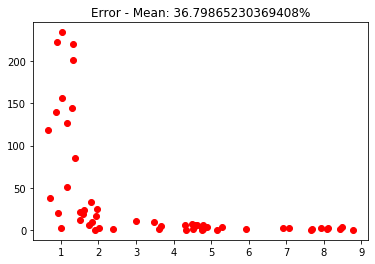

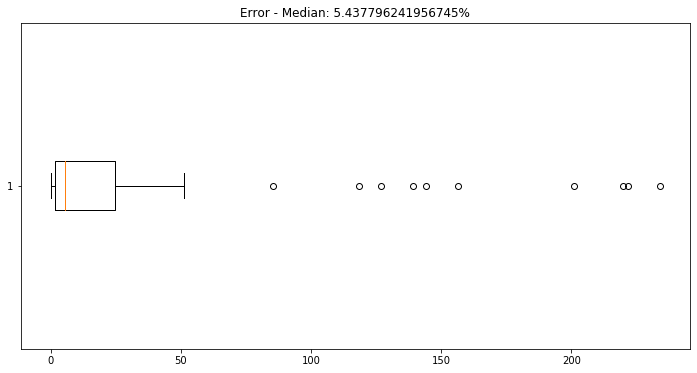

,0
count,55.000000
mean,36.798652
std,65.128884
min,0.153012
25%,1.875619
50%,5.437796
75%,24.670359
max,233.963590


In [5]:
plt.plot(y_scaler.inverse_transform(y),results, 'ro')
plt.title(f'Error - Mean: {results_df.iloc[:,0].mean()}%')
plt.show()
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
plt.boxplot(results_df.iloc[:,0], vert=False)
plt.title(f'Error - Median: {results_df.iloc[:,0].median()}%')
plt.show()
results_df.describe()